In [23]:
# Import python libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime
import wikipediaapi
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
style.use('ggplot')

# Specify which US State to analyze:
state = "Maryland"


In [2]:
# Load data function
def load_data(data_url, file_name, column_name):
    data = pd.read_csv(data_url + file_name) \
             .drop(['Lat', 'Long'], axis=1) \
             .melt(id_vars=['Province/State', 'Country/Region'], \
                   var_name='date', value_name=column_name) \
             .fillna('<all>')
    data['date'] = data['date'].astype('datetime64[ns]')
    return data

In [3]:
# Read the data from the JHU Database
data_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
data = load_data(data_url, "time_series_19-covid-Confirmed.csv", "CumConfirmed")
#print(data.head())

In [4]:
# Analyze the country/region portion of the data
countries = data['Country/Region'].unique()
countries.sort()
#print(countries)

In [5]:
# Retain just the US data
us_data = data[data['Country/Region']=="US"].drop(["Country/Region"],axis=1)
us_data.reset_index(inplace=True, drop=True)
#print(us_data)

In [6]:
# Analyze the province/state portion of the data
states = data['Province/State'].unique()
states.sort()
#print(len(states))

In [7]:
# Retain just the state-of-interest data
state_data = us_data[us_data['Province/State']==state].drop(["Province/State"],axis=1)
state_data.reset_index(inplace=True, drop=True)
#print(state_data)

In [8]:
# Create new column with days since first case
state_data = state_data.iloc[state_data["CumConfirmed"].nonzero()[0]].reset_index(drop=True)
state_data["DaysSinceFirstCase"] = np.arange(state_data.shape[0])

In [9]:
# Read information from wikipedia
wiki = wikipediaapi.Wikipedia('en')
if state == "Washington":
    state = "Washington (state)"
state_wiki = wiki.page("2020 coronavirus pandemic in {}".format(state.replace(' ','_')))
#print(state_wiki.text)

In [45]:
# Extract the government response section
gov_resp_indx = state_wiki.text.lower().find("government response")
end_gov_resp_indx = state_wiki.text.lower().find("impact on sports")
if end_gov_resp_indx == -1:
    end_gov_resp_indx = state_wiki.text.lower().find("effects on sports")    
gov_resp_text = state_wiki.text[gov_resp_indx:end_gov_resp_indx].replace('\n','')
#print(gov_resp_text)

sentences = sent_tokenize(gov_resp_text.replace('.','. '))

# Find sentences with dates in government responses
months = [
    "On January", 
    "On February", 
    "On March", 
    "On April", 
    "On May", 
    "On June", 
    "On July", 
    "On August", 
    "On October", 
    "On November", 
    "On December",
    ]
sentences_indx = []
for month in months:
    sentences_indx = sentences_indx + [i for i in range(len(sentences)) if str(sentences[i]).startswith(month)] 
actions = []
for indx in sentences_indx:
    actions.append(sentences[indx])
#print(actions[0])

In [47]:
# Find sentences corresponding with date indicies
action_dates = []
for i in range(len(actions)):
    date_indx_end = actions[i].find(',')
    date_raw = actions[i][0+3:date_indx_end]
    action_dates.append(date_raw)
print(action_dates)
print(actions)

# Convert action dates to YYYY-MM-DD format
def month_to_num(month):
    return{
        'January' : 1,
        'February' : 2,
        'March' : 3,
        'April' : 4,
        'May' : 5,
        'June' : 6,
        'July' : 7,
        'August' : 8,
        'September' : 9, 
        'October' : 10,
        'November' : 11,
        'December' : 12
    }[month]

converted_dates = []
for action_date in action_dates:
    space_indx = action_date.find(' ')
    month_num = month_to_num(action_date[:space_indx])
    date_num = action_date[space_indx+1:]
    converted_dates.append("2020-{}-{}".format(str(month_num).zfill(2), str(date_num).zfill(2)))
#print(converted_dates)

['March 12', 'March 15', 'March 15', 'March 16', 'March 23']
['On March 12, Governor Hogan declared all Maryland public schools were to be closed from March 16 through March 27, gatherings of more than 250 people were banned, and the Maryland National Guard was activated to a higher state of readiness.', 'On March 15, Governor Hogan ordered all Maryland casinos, racetracks, and off-track betting parlors to shut down to help prevent the spread of coronavirus.', 'On March 15, Howard County Executive Calvin Ball declared a state of emergency in Howard County following the first confirmed case of coronavirus in the county.', 'On March 16, Governor Hogan signed an executive order banning gatherings of over 50 people as recommended by the CDC.', 'On March 23, Governor Larry Hogan ordered all non-essential businesses in the state to close effective at 5 p. m.  Monday to prevent further spread of COVID-19.']


In [48]:
# Add column in dataframe for government actions
state_data["GovAction"] = "none"
for i, date in enumerate(converted_dates):
    if date in str(state_data["date"].values):
        state_data.loc[state_data.loc[state_data["date"] == date].index[0], "GovAction"] = str(actions[i])
#print(state_data)

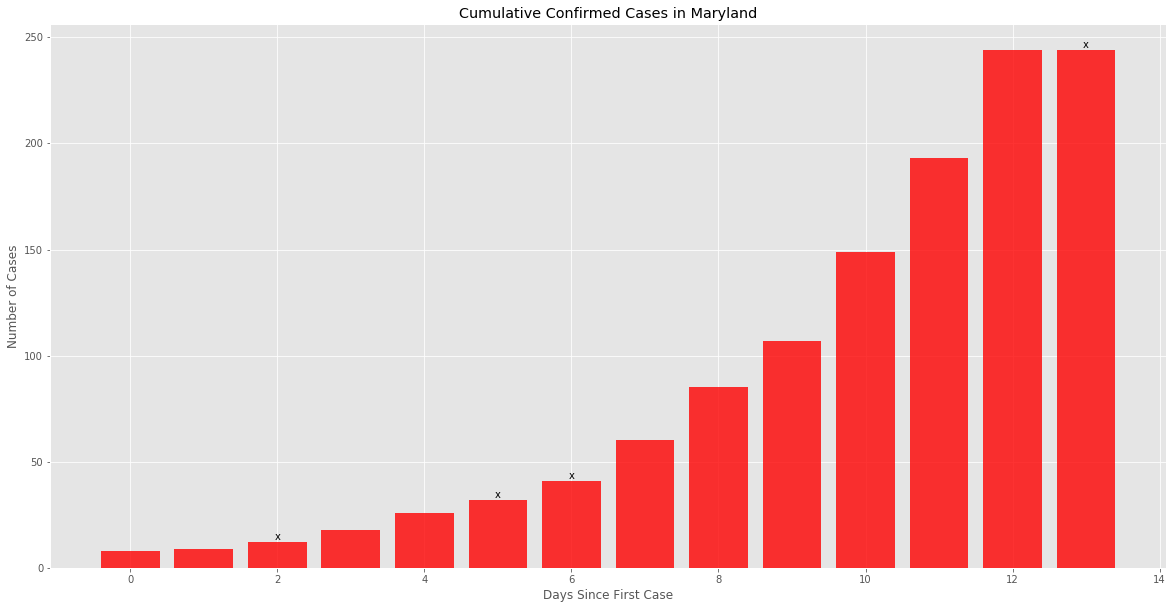

Day 2: On March 12, Governor Hogan declared all Maryland public schools were to be closed from March 16 through March 27, gatherings of more than 250 people were banned, and the Maryland National Guard was activated to a higher state of readiness.

Day 5: On March 15, Howard County Executive Calvin Ball declared a state of emergency in Howard County following the first confirmed case of coronavirus in the county.

Day 6: On March 16, Governor Hogan signed an executive order banning gatherings of over 50 people as recommended by the CDC.

Day 13: On March 23, Governor Larry Hogan ordered all non-essential businesses in the state to close effective at 5 p. m.  Monday to prevent further spread of COVID-19.



In [49]:
# Plot the data
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
fig_state = ax.bar(state_data["DaysSinceFirstCase"],state_data["CumConfirmed"], color='r', alpha=0.8)
plt.title("Cumulative Confirmed Cases in {}".format(state))
plt.xlabel("Days Since First Case")
plt.ylabel("Number of Cases")

# Add tick mark at events
for i, fig in enumerate(fig_state):
    x = fig.get_x()
    wid = fig.get_width()
    height = state_data["CumConfirmed"].values[i]
 
    if state_data["GovAction"][i] != "none":
        ax.text(x + wid/2., height, "x", ha='center', va='bottom', rotation=0)

plt.show()

# Label tick mark events
for i in range(state_data.shape[0]):
    if state_data["GovAction"][i] != "none":
        print("Day {}: {}\n".format(i, state_data["GovAction"][i]))


In [50]:
# Extract just the new cases data from the cumulative confirmed
state_data["NewCases"] = state_data["CumConfirmed"].diff()
state_data.loc[0,"NewCases"] = state_data["CumConfirmed"][0]

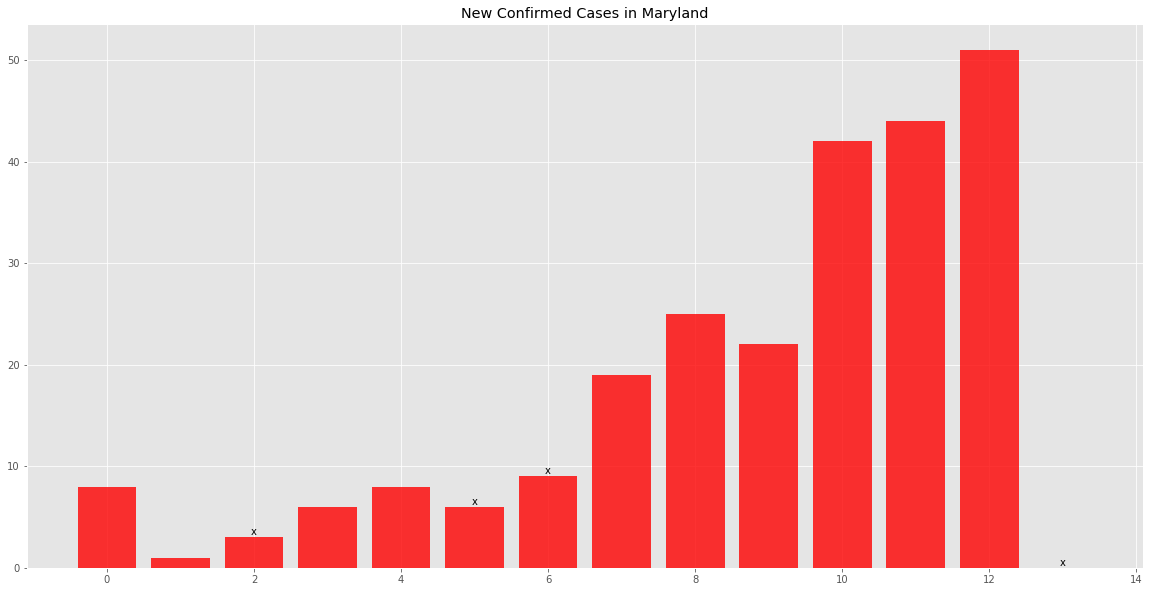

Day 2: On March 12, Governor Hogan declared all Maryland public schools were to be closed from March 16 through March 27, gatherings of more than 250 people were banned, and the Maryland National Guard was activated to a higher state of readiness.

Day 5: On March 15, Howard County Executive Calvin Ball declared a state of emergency in Howard County following the first confirmed case of coronavirus in the county.

Day 6: On March 16, Governor Hogan signed an executive order banning gatherings of over 50 people as recommended by the CDC.

Day 13: On March 23, Governor Larry Hogan ordered all non-essential businesses in the state to close effective at 5 p. m.  Monday to prevent further spread of COVID-19.



In [51]:
# Plot the new cases data
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
fig_state = ax.bar(state_data["DaysSinceFirstCase"],state_data["NewCases"], color='r', alpha=0.8)
plt.title("New Confirmed Cases in {}".format(state))

# Add tick mark at events
for i, fig in enumerate(fig_state):
    x = fig.get_x()
    wid = fig.get_width()
    height = state_data["NewCases"].values[i]
    
    if state_data["GovAction"][i] != "none":
        ax.text(x + wid/2., height, "x", ha='center', va='bottom', rotation=0)
    
plt.show()

# Label tick mark events
for i in range(state_data.shape[0]):
    if state_data["GovAction"][i] != "none":
        print("Day {}: {}\n".format(i, state_data["GovAction"][i]))